In [1]:
import MPPIController
import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.integrate import odeint

plt.style.use(["science", "grid"])

# Block on a slope

Try MPPI controller with a simple block on a slope.

In [ ]:
class BlockOnSlope:
    # Apply a force parallel to the slope to achieve a desired position
    # and velocity of the block
    
    def __init__(self, initial_state, block_mass, slope_angle, g, dt):
        self.initial_state = initial_state
        self.desired_state = None
        self.block_mass = block_mass
        self.slope_angle = slope_angle
        self.g = g
        self.dt = dt
        self.nx, self.nu = (2, 1)
        self.NULL_ACTION  = np.zeros(self.nu)
        
        self.controller = MPPIController.MPPIController(
            n_rollouts=200,
            horizon_length=10,
            exploration_cov=np.diag([15 ** 2]),
            exploration_lambda=1e-3,
            nx=self.nx,
            nu=self.nu,
            terminal_cost=self.terminal_cost,
            state_cost=self.state_cost,
            evolve_state=self.evolve_state,
            dt=dt,
            control_range={"min": np.array([-80]), "max": np.array([80])},
            control_noise_initialization = MPPIController.ControlNoiseInit.RANDOM
        )
    
    def dynamics(self, u):
        def dydt(y, t):
            pos, vel = y
            accel = (g * np.sin(sa)) + (u[0] / m)
            
            return np.array([vel, accel])
        return dydt

    def terminal_cost(self, x):
        error = (self.desired_state - x)
        Q = np.diag([3, 1])
        
        return error.T @ Q @ error

    def state_cost(self, x):
        error = (self.desired_state - x)
        Q = np.diag([1, 1])
        
        return error.T @ Q @ error
    
    def evolve_state(self, x, u, dt):
        pos, vel = x
        accel = (self.g * np.sin(self.slope_angle)) + (u[0] / self.block_mass)
        
        newvel = vel + accel * dt
        newpos = pos + newvel * dt + 0.5 * accel * (dt ** 2)
        
        evolved_state = np.array([newpos, newvel])

        return evolved_state
    
    def simulator(self, x, u):
        return self.evolve_state(x, u, dt=dt)

In [ ]:
dt = 1 / 10

block_env = BlockOnSlope(
    initial_state=np.array([0.0, 0.0]),
    block_mass=5,
    slope_angle=np.radians(30),
    g=-9.81,
    dt=dt
)

block_env.desired_state = np.array([5, 0])

In [ ]:
# Create lists to store control sequence and state sequences for MPPI runs
control_seq, states = [], []

simulation_length = 8  # s
n_steps = int((1 / dt) * simulation_length)

# Begin simulation
current_state = block_env.initial_state
start_time = perf_counter()

for _ in range(0, n_steps):
    action = block_env.controller.step(current_state)
    current_state = block_env.simulator(current_state, action)
    
    states.append(current_state[0])
    control_seq.append(action)

print("Elapsed Time: {:.5f} s".format(perf_counter() - start_time))

In [ ]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Block on Slope Response")

time = np.linspace(0, simulation_length, n_steps)
ax1.plot(time, states, label="block position")
ax1.plot(time, np.repeat(block_env.desired_state[0], n_steps), label="desired position")
ax1.set(xlabel="time (s)", ylabel="position (m)")
ax1.legend()

ax2.plot(time, control_seq, label="control")
ax2.set(xlabel="time (s)", ylabel="force (N)")

plt.show()

# Pendulum
Try MPPI controller with a pendulum:
![alternatvie text](http://underactuated.mit.edu/figures/simple_pend.svg)

The state-space representation of the system is $x = (\theta, \dot{\theta})$, $u = \tau$, and the dynamics of the inverted pendulum are given by:
$$
\begin{align*}
    \dot{\theta} &= \dot{\theta} \\
    \ddot{\theta} &= \frac{\tau - mgl\sin(\theta) - b\dot{\theta}}{ml^2}
\end{align*}
$$

In [362]:
class Pendulum:
    def __init__(self, initial_state, m, l, b, dt):
        self.initial_state = initial_state
        self.desired_theta = np.pi
        self.desired_omega = 0.0
        self.m = m
        self.l = l
        self.b = b
        self.g = 9.81
        self.dt = dt
        self.nx, self.nu = (2, 1)
        self.NULL_ACTION  = np.zeros(self.nu)
                        
        self.controller = MPPIController.MPPIController(
            n_rollouts=200,
            horizon_length=20,
            exploration_cov=np.diag([0.5 ** 2]),
            exploration_lambda=1e-3,
            nx=self.nx,
            nu=self.nu,
            terminal_cost=self.terminal_cost,
            state_cost=self.state_cost,
            evolve_state=self.evolve_state,
            dt=dt,
            control_range={"min": np.array([-4]), "max": np.array([4])},
            control_noise_initialization = MPPIController.ControlNoiseInit.LAST
        )
        
        self.measurement_noise_cov = np.array([
            [(3 * np.pi / 180) ** 2]  # 5 degrees of measurement noise
        ])
            
    def transform_angle_error(self, error):
        if error > np.pi:
            return 2 * np.pi - error
        elif error < -np.pi:
            return -2 * np.pi - error
        return error
    
    def terminal_cost(self, x):
        theta, omega = x
        
        theta_error = self.transform_angle_error(self.desired_theta - theta)
        omega_error = self.desired_omega - omega
        
        error = np.array([theta_error, omega_error])
            
        Q = np.diag([1, 1])
        
        return error.T @ Q @ error

    def state_cost(self, x):
        theta, omega = x
        
        theta_error = self.transform_angle_error(self.desired_theta - theta)
        
        error = np.array([theta_error])
            
        Q = np.diag([1])
        
        return error.T @ Q @ error

    def evolve_state(self, x, u, dt):
        theta, thetadot = x
        tau = u[0]
        
        m, l, b, g = self.m, self.l, self.b, self.g
        
        thetaddot = (1 / (m * l**2)) * (tau - m * g * l * np.sin(theta) - b * thetadot)
        
        new_state = np.array([
            theta + thetadot * dt + (1/2 * thetaddot * dt**2),
            thetadot + thetaddot * dt
        ])
        
        return new_state
    
    def simulator(self, x, u, measurement_noise=False):
        curr_state = self.evolve_state(x, u, dt=self.dt)
        if measurement_noise:
            noise = np.random.multivariate_normal(np.zeros_like(u), cov=self.measurement_noise_cov,
                                                  size=1)[0]
            curr_state += noise
        
        return curr_state

In [363]:
dt = 1 / 10

pend_env = Pendulum(
    initial_state=np.array([np.radians(0), 0]),
    m=1,     # kg
    l=1,     # m
    b=0.1,   # ?
    dt=dt    # s
)

pend_env.desired_theta = np.pi
pend_env.desired_omega = 0.0

initial last seq [[-1.54354763]
 [-2.33661044]
 [-2.13721184]
 [-3.68752349]
 [ 0.8786938 ]
 [-2.0535309 ]
 [ 1.36945812]
 [ 3.07570105]
 [ 0.21401516]
 [ 2.41054584]
 [ 2.7850378 ]
 [ 2.21007135]
 [-2.86067995]
 [-1.00960785]
 [ 0.25377167]
 [ 1.77712238]
 [ 2.24814871]
 [ 0.66877781]
 [ 0.40153596]
 [-3.14696015]]


In [364]:
simulation_length = 8  # s
n_steps = int((1 / dt) * simulation_length)

# Create lists to store control sequence and state sequences for MPPI runs
controls, states = np.empty((n_steps, pend_env.nu)), np.empty((n_steps, pend_env.nx))

# Begin simulation
current_state = pend_env.initial_state
start_time = perf_counter()

for i in range(0, n_steps):
    action = pend_env.controller.step(current_state)
    current_state = pend_env.simulator(current_state, action, measurement_noise=False)
    
    states[i] = current_state
    controls[i] = action

print("Elapsed Time: {:.5f} s".format(perf_counter() - start_time))

Elapsed Time: 6.17886 s


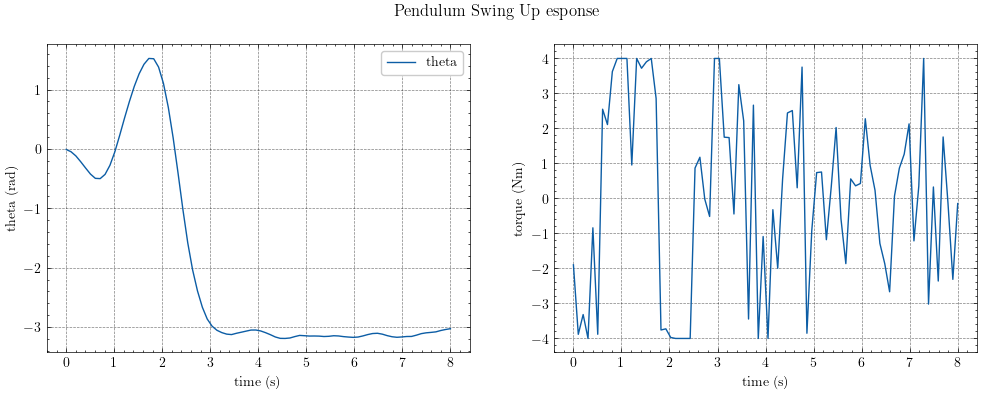

In [365]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle("Pendulum Swing Up esponse")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, states[:, 0], label="theta")
ax1.set(xlabel="time (s)", ylabel="theta (rad)")
# ax1.set_ylim([-np.pi-0.3, np.pi+0.3])
ax1.legend()

ax2.plot(time, controls[:, 0], label="control")
ax2.set(xlabel="time (s)", ylabel="torque (Nm)")

fig.savefig("pendulum_swingup.png")

# Cart-Pole
Try MPPI controller with a cart-pole system:

![alternatvie text](http://underactuated.mit.edu/figures/cartpole.svg)

The state-space representation of the system is $x = (x, \dot{x}, \theta, \dot{\theta})$, $u = f_x$, and the dynamics of the inverted pendulum are given by:
$$
\begin{align*}
    \dot{x} &= \dot{x} \\
    \ddot{x} &= \frac{1}{m_c+m_p\sin^2(\theta)} \left( f_x + m_p\sin(\theta) (l\dot{\theta}^2 + g\cos(\theta)) \right) \\
    \dot{\theta} &= \dot{\theta} \\
    \ddot{\theta} &= \frac{1}{l(m_c+m_p\sin^2(\theta))} \left( -f_x\cos(\theta) - m_p l \dot{\theta}^2 \cos(\theta)\sin(\theta) - (m_c + m_p)g\sin(\theta) \right)
\end{align*}
$$

In [277]:
class CartPole:
    def __init__(self, initial_state, m_pole, m_cart, l, dt):
        self.initial_state = initial_state
        self.desired_theta = 0
        self.desired_velocity = 0
        self.m_pole = m_pole
        self.m_cart = m_cart
        self.l = l
        self.dt = dt
        self.g = 9.81
        self.nx, self.nu = (4, 1)
        self.NULL_ACTION  = np.zeros(self.nu)
                        
        self.controller = MPPIController.MPPIController(
            n_rollouts=300,
            horizon_length=10,
            exploration_cov=np.diag([0.5 ** 2]),
            exploration_lambda=1e-6,
            nx=self.nx,
            nu=self.nu,
            terminal_cost=self.terminal_cost,
            state_cost=self.state_cost,
            evolve_state=self.evolve_state,
            dt=dt,
            control_range={"min": np.array([-5]), "max": np.array([5])},
            control_noise_initialization = MPPIController.ControlNoiseInit.LAST
        )
        
        self.measurement_noise_cov = np.array([
            [(3 * np.pi / 180) ** 2]  # 5 degrees of measurement noise
        ])
        
    def transform_angle_error(self, theta_error):
        if theta_error > np.pi:
            return 2 * np.pi - theta_error
        elif theta_error < -np.pi:
            return -2 * np.pi - theta_error
        return theta_error
    
    def terminal_cost(self, x):
        pos, posdot, theta, thetadot = x
        
        theta_error = self.transform_angle_error(self.desired_theta - theta)
        vel_error = self.desired_velocity - posdot
        
        error = np.array([theta_error, vel_error])
        
        Q = np.diag([1, 1])
        
        return error.T @ Q @ error

    def state_cost(self, x):
        pos, posdot, theta, thetadot = x
        
        theta_error = self.transform_angle_error(self.desired_theta - theta)
        vel_error = self.desired_velocity - posdot
        
        error = np.array([theta_error, vel_error])
        
        Q = np.diag([1, 1])
        
        return error.T @ Q @ error

    def evolve_state(self, x, u, dt):
        # https://danielpiedrahita.wordpress.com/portfolio/cart-pole-control/
        f_x = u[0]
        m_p, m_c, l, g, dt = self.m_pole, self.m_cart, self.l, self.g, self.dt
            
        pos, posdot, theta, thetadot = x
        posddot = (1 / (m_c + m_p * (np.sin(theta)**2))) * \
                  ( f_x + m_p * np.sin(theta) * (l * (thetadot**2) + g * np.cos(theta)) )
                
        thetaddot = (1 / (l * (m_c + m_p * (np.sin(theta)**2)))) * \
                   (-f_x * np.cos(theta) + \
                    -m_p * l * (thetadot**2) * np.cos(theta) * np.sin(theta) + \
                    -(m_c + m_p) * g * np.sin(theta))
        
        new_state = np.array([
            pos + posdot*dt + 1/2 * posddot * dt**2,
            posdot + posddot * dt,
            theta + thetadot*dt + 1/2 * thetaddot * dt**2,
            thetadot + thetaddot * dt
        ])
        
        return new_state
    
    def simulator(self, x, u, measurement_noise=False):
        curr_state = self.evolve_state(x, u, dt=self.dt)
        if measurement_noise:
            noise = np.random.multivariate_normal(np.zeros_like(u), cov=self.measurement_noise_cov,
                                                  size=1)[0]
            curr_state += noise
        
        return curr_state

In [279]:
dt = 1 / 8

cart_pole_env = CartPole(
    initial_state=np.array([0, 0, 0, 0]),
    m_pole=1,
    m_cart=1,
    l=1,
    dt=dt
)

cart_pole_env.desired_theta = np.pi
cart_pole_env.desired_velocity = 0.0

initial last seq [[ 0.96653751]
 [-1.29059389]
 [-3.05978538]
 [ 1.33665307]
 [-2.55588462]
 [ 2.84121151]
 [-4.77548781]
 [-3.99106675]
 [ 3.06538535]
 [ 0.53237223]]


In [287]:
simulation_length = 13  # s
n_steps = int((1 / dt) * simulation_length)

# Create lists to store control sequence and state sequences for MPPI runs
controls, states = np.empty((n_steps, cart_pole_env.nu)), np.empty((n_steps, cart_pole_env.nx))

# Begin simulation
current_state = cart_pole_env.initial_state
start_time = perf_counter()

for i in range(0, n_steps):
    action = cart_pole_env.controller.step(current_state)
    current_state = cart_pole_env.simulator(current_state, action, measurement_noise=False)
    
    states[i] = current_state
    controls[i] = action

print("Elapsed Time: {:.5f} s".format(perf_counter() - start_time))

Elapsed Time: 10.87814 s


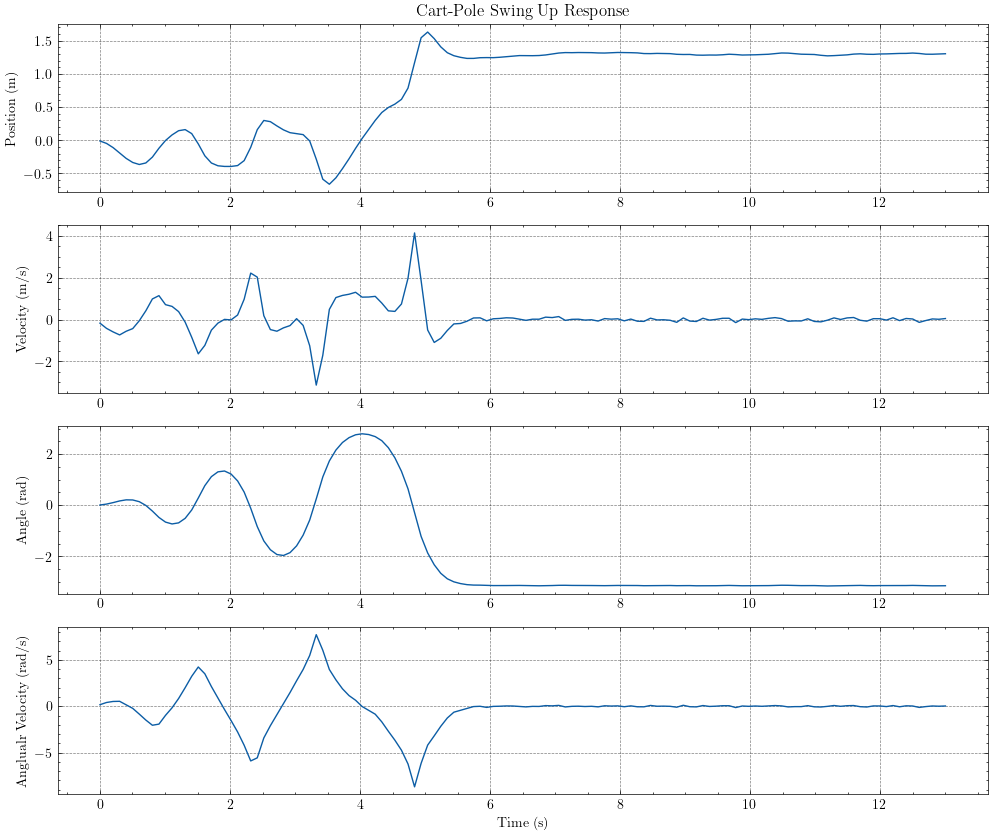

In [288]:
# Plot the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

# fig.suptitle("Cart-Pole Response")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, states[:, 0])
ax1.set(ylabel="Position (m)", title="Cart-Pole Swing Up Response")

ax2.plot(time, states[:, 1])
ax2.set(ylabel="Velocity (m/s)")

ax3.plot(time, states[:, 2])
ax3.set(ylabel="Angle (rad)")

ax4.plot(time, states[:, 3])
ax4.set(ylabel="Anglualr Velocity (rad/s)")

plt.xlabel("Time (s)")
# ax2.plot(time, controls[:, 0], label="control")
# ax2.set(xlabel="Time (s)", ylabel="Torque (Nm)")

fig.savefig("cartpole_swingup.png")